<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble._forest import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

Грузим библиотеку для обработи текста и стоп-слова из английского языка

In [2]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Читаю исходный файл

In [3]:
df=pd.read_csv('/datasets/toxic_comments.csv')
df_b = df
display(df)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df['text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159287    ":::::And for the second time of asking, when ...
159288    You should be ashamed of yourself \n\nThat is ...
159289    Spitzer \n\nUmm, theres no actual article for ...
159290    And it looks like it was actually you who put ...
159291    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

Функция РОS-тэгирования слов.Результатом будет список кортежей, в котором каждый кортеж содержит слово и его POS-тэг(часть речи)

In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

Создал процедуру для предобработки отзывов, которая включает приведение слов в нижний регистр, удаление интернет ссылок, если они есть, удаление всех лишних символов, токенизацию, лемматизацию c POS-тегетированием слов и обединение через пробел преобразований для каждого отзыва.

In [7]:
def preprocess_text(text):
    text=text.lower()
    text=re.sub(r'http\S+|www\S+|http\S+',' ',text)
    text=re.sub(r'[^a-zA-Z]',' ',text)
    tokens=nltk.word_tokenize(text)
    #tokens=[token for token in tokens if token not in stop_words]
    #tokens=[lemmatizer.lemmatize(token) for token in tokens]
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    processed_text=' '.join(tokens)
    return processed_text


In [8]:
lemmatizer = WordNetLemmatizer()

Проверяю на примере первого отзыва в датасете как он выглядел до преобразований

In [9]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Проверяю тот же самый первый отзыв в датасете после преобразований преобразований

In [10]:
preprocess_text(df['text'][0])

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

Применяю преобразование на всем столбце с отзывами

In [11]:
df['text'] = df['text'].apply(lambda x:preprocess_text(x))

Удаляю столбец 'Unnamed: 0':

In [12]:
df = df.drop(['Unnamed: 0'], axis=1)

In [13]:
df

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159287,and for the second time of ask when your view ...,0
159288,you should be ashamed of yourself that be a ho...,0
159289,spitzer umm there no actual article for prosti...,0
159290,and it look like it be actually you who put on...,0


Выделим из датасета целевой и нецелевой признаки

In [14]:
features=df.drop('toxic',axis=1)
target=df.toxic

Посмотрим на количество строк с разными классами: датасет очень несбалансирован в сторону 0 (в около 9 раз). Для не градиентных моделей буду использовать параметр class_weight='balanced', в градиентных моделях борьба с дисбалансом классов реализована внутри.

In [15]:
target.value_counts()


0    143106
1     16186
Name: toxic, dtype: int64

Разделяю признаки на тренировочную и тестовую выборки в соотношении 0.80/0.20 Валидационную не делаю, так как буду использовать поиск параметров моделей через GRidSearchCV, в котором реализована кросс валидация. 

In [16]:
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                                                            test_size=0.20, random_state=12345,\
                                                                            stratify=target)

In [17]:
features_train = features_train.text

## Обучение

In [18]:
%%time
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=stop_words,analyzer='word')),
        ("clf", LogisticRegression())
        
    ]
)
    
parameters = [{
              'clf':[LogisticRegression(random_state = 12345)],
              'clf__solver': ['lbfgs'],
              'clf__C': [5, 10],
              'clf__max_iter': [100,300],
              'clf__class_weight': ['balanced'],
             },
             {
              'clf':[RandomForestClassifier(random_state = 12345)],
              'clf__max_depth': [15,20],
              'clf__n_estimators': [150,200],
              'clf__class_weight': ['balanced'],
             },  
             {
              'clf':[LGBMClassifier()], 
              'clf__max_depth': [15, 25],
              'clf__learning_rate': [0.1, 0.3],
              'clf__boosting_type':['gbdt'],
             }]

grid = GridSearchCV(pipeline, parameters, scoring='f1', cv=2, n_jobs=-1, verbose = 3)
grid.fit(features_train, target_train)
grid.best_params_


Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END clf=LogisticRegression(random_state=12345), clf__C=5, clf__class_weight=balanced, clf__max_iter=100, clf__solver=lbfgs; total time=  43.2s
[CV 2/2] END clf=LogisticRegression(random_state=12345), clf__C=5, clf__class_weight=balanced, clf__max_iter=100, clf__solver=lbfgs; total time=  40.2s
[CV 1/2] END clf=LogisticRegression(random_state=12345), clf__C=5, clf__class_weight=balanced, clf__max_iter=300, clf__solver=lbfgs; total time= 1.1min
[CV 2/2] END clf=LogisticRegression(random_state=12345), clf__C=5, clf__class_weight=balanced, clf__max_iter=300, clf__solver=lbfgs; total time=  52.7s
[CV 1/2] END clf=LogisticRegression(random_state=12345), clf__C=10, clf__class_weight=balanced, clf__max_iter=100, clf__solver=lbfgs; total time=  42.0s
[CV 2/2] END clf=LogisticRegression(random_state=12345), clf__C=10, clf__class_weight=balanced, clf__max_iter=100, clf__solver=lbfgs; total time=  40.5s
[CV 1/2] END clf=Logistic

{'clf': LGBMClassifier(learning_rate=0.3, max_depth=25),
 'clf__boosting_type': 'gbdt',
 'clf__learning_rate': 0.3,
 'clf__max_depth': 25}

In [19]:
print('метрика f1-->', grid.best_score_)

метрика f1--> 0.757269325410213


Конвейерная векторизация входных данных и обучение 3х моделей показало, что наиболее качественное предсказание у модели градиентного бустинга LGBMClassifier со значением метрики F1=0.76. Эту модель будем использовать для предсказания на тестовой выборке.

In [20]:
features_test=features_test.text

In [21]:
target_predict= grid.predict(features_test)
f1=f1_score(target_test,target_predict)
print('метрика f1-->', f1)

метрика f1--> 0.7749653259361997


Как видно, выбранная модель сохранила качество предсказания и показывает значение метрики F1 выше чем на тренировочной выборке и чем поставлено в задании.

Обучение логической регрессии на эмбеддирнгах BERT. Для проверки кода исходный датасет надо загрузить в Colab в папку content.

https://colab.research.google.com/drive/1zxZcYCevujC5j0AQYn1XTObL_jAGhY98?usp=sharing

Вывод: F1=0.80 > 0.75, что означает, что обученная логистическая регрессия на эмбеддингах, как модель классификации отзывов на позитивные и негативные, идеально подходит для качественных предсказаний.

## Выводы

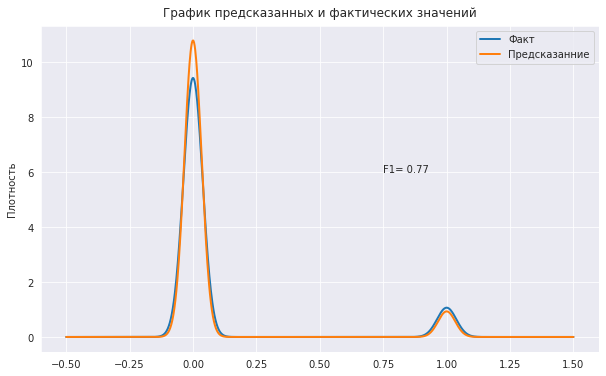

In [23]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(target_predict).plot(kind='kde',linewidth=2)
plt.title('График предсказанных и фактических значений', y=1.01)
plt.legend(['Факт','Предсказанние'])
plt.text(0.75,6,'F1= {:.2f}'.format(f1))
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

Перед нами стояла задача обучить модели классифицировать комментарии на позитивные и негативные, на базе данных с отзывами на товары в интернет_магазине с разметкой о токсичности этих отзывов. Была поставлена задача достичь метрики качества предсказания модели F1 не более 0,75.

В исходный датасет был изучен, данные предобработаны, удалены лишние символы, токенизирован и лемматизирован.
На подготовленных данных были через Pipeline были обучены и протестированы несколько моделей LogisticRegressorClasifier,RandomForestClassifier,LightGBM c подбором разных гиперпараметров. CatBoostRegressorClassifier на обучении, к сожалению, постоянно останавливался из-за технических проблем.   

В результате конвейерной векторизации и обучения модель LightGBMClassifier на тренировочной выборке достигла лучше чем заданное значения метрики. Для предсказания на тестовой выюорке быда отобрана модель LightGBMClasifier тк на обучении она показала наилучший результат.Значение метрики F1 на тесте **LightGBMClasifier = 0.775**, что укладывается в заданные параметры.

Дополнительно было проведено обучение логической регрессии на эмбеддирнгах BERT в google colab.После проверки модели на тестовой выборке получили F1=0.80 > 0.75, что означает, что обученная логистическая регрессия на эмбеддингах по условиям задачи отлично подходит для качественного предсказания как модель классификации отзывов на позитивные и негативные.
